# 1. Tensorflow basics

In [1]:
%matplotlib notebook
import tensorflow as tf
import numpy as np
import gym
import random
from collections import deque
import matplotlib.pyplot as plt


#### In Tensorflow the computation graph has to be constructed before the actual computation can take place

In [ ]:
# Hello world! in Tensorflow
hello = tf.constant('Hello world!')

In [ ]:
print(hello)

In [ ]:
# start a Tensorflow session
session = tf.Session()

In [ ]:
# run the graph we just built
# .decode() interprets the bytestring coming from tensorflow
print(session.run(hello).decode())

In [ ]:
# Basic constant operations
# The value returned by the constructor represents the output
# of the Constant op
const1 = tf.constant(5)
const2 = tf.constant(10)

# Launch the default graph.
with tf.Session() as sess:
    print("Constant 1: {}".format(sess.run(const1)), "Constant 2: {}".format(sess.run(const2)))
    print("Addition result of the two constants: {}".format(sess.run(const1+const2)))
    print("Multiplication result of the two constants: {}".format(sess.run(const1*const2)))

In [ ]:
# replace constants with variables
var1 = tf.placeholder(tf.int16)
var2 = tf.placeholder(tf.int16)

# define the addition and multiplication operations
# these operations are defined in the graph, but not yet performed
add = tf.add(var1, var2)
multiply = tf.multiply(var1, var2)

In [ ]:
# To run the matmul op we call the session 'run()' method, passing 'add' or 'multiply'
# which represents the output of the op defined above.
#
# All inputs needed by the op are run automatically by the session.  They
# typically are run in parallel.
#
# The call 'run(multiply)' thus causes the execution of threes ops in the
# graph: the two variables and the multiply op.
#
# The output of the op is returned in 'addition_result' as a numpy `ndarray` object.
with tf.Session() as sess:
    print("Addition result of the two variables: {}".format(sess.run(add,
                                                                     feed_dict={var1:3, var2:5})))
    print("Multiplication result of the two variables: {}".format(sess.run(multiply, feed_dict={var1:3, var2:5})))



In [ ]:
# Create a Constant op that produces a 1x2 matrix.  The op is
# added as a node to the default graph.
matrix1 = tf.constant([[3., 3.]])

# Create another Constant that produces a 2x1 matrix.
matrix2 = tf.constant([[2.],[2.]])

In [ ]:
# Create a Matmul op that takes 'matrix1' and 'matrix2' as inputs.
# The returned value, 'product', represents the result of the matrix
# multiplication.
matrix_product = tf.matmul(matrix1, matrix2)

In [ ]:
# run the graph and get the result
with tf.Session() as sess:
    result = sess.run(matrix_product)
    print("Multiplication result of the two matrices: {}".format(result))

# Implement Q-learning with a table

In [ ]:
env = gym.make('FrozenLake-v0')

In [ ]:
print(env.action_space.n)

In [ ]:
# Initialize table with all zeros
Q = np.zeros([env.observation_space.n,env.action_space.n])
# Set learning parameters
learn_rate = .8
gamma = .95
num_episodes = 2000
reward_list = []
for i in range(num_episodes):
    # Reset environment and get first new observation
    state = env.reset()
    reward_epoch = 0
    done = False
    ep_length = 0
    # The Q-Table learning algorithm
    while ep_length < 99:
        ep_length += 1
        # Choose an action by greedily (with noise) picking from Q table
        action = np.argmax(Q[state,:] + np.random.randn(1,env.action_space.n)*(1./(i+1)))
        # Get new state and reward from environment
        new_state, reward, done, _ = env.step(action)
        # Update Q-Table with new knowledge
        Q[state,action] = Q[state,action] + learn_rate*(reward +
                                                        gamma*np.max(Q[new_state,:]) - Q[state,action])
        reward_epoch += reward
        state = new_state
        if done == True:
            break
    reward_list.append(reward_epoch)

In [ ]:
print("Score over time: " +  str(sum(reward_list)/num_episodes))
print("Final Q-Table Values", Q)

In [ ]:
print(len(reward_list))

In [ ]:
plt.plot(reward_list)

# Implement Q-learning with a neural network

In [ ]:
env = gym.make('FrozenLake-v0')

In [ ]:
tf.reset_default_graph()

In [ ]:
# These lines establish the feed-forward part of the network used to choose actions
inputs = tf.placeholder(shape=[1,16],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4],0,0.01))
Qout = tf.matmul(inputs, W)
predict = tf.argmax(Qout, 1)

# Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4], dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

In [ ]:
init = tf.initialize_all_variables()

# Set learning parameters
gamma = .99
epsilon = 0.1
num_episodes = 2000
# create lists to contain total rewards and steps per episode
step_list = []
reward_list = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        # Reset environment and get first new observation
        state = env.reset()
        reward_episode = 0
        done = False
        ep_length = 0
        while ep_length < 99:
            ep_length+=1
            action, allQ = sess.run([predict, Qout],
                                    feed_dict={inputs:np.identity(16)[state:state+1]})
            if np.random.rand(1) < epsilon:
                action[0] = env.action_space.sample()
            # Get new state and reward from environment
            new_state, reward, done,_ = env.step(action[0])
            # Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout, feed_dict={inputs:np.identity(16)[new_state:new_state+1]})
            # Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0, action[0]] = reward + gamma*maxQ1
            # Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs:np.identity(16)[state:state+1],
                                                       nextQ:targetQ})
            reward_episode += reward
            state = new_state
            if done == True:
                # Reduce chance of random action as we train the model.
                epsilon = 1./((i/50) + 10)
                break
        step_list.append(ep_length)
        reward_list.append(reward_episode)
print("Percent of succesful episodes: {}%".format(str(sum(reward_list)/num_episodes)))

In [ ]:
plt.plot(reward_list)

In [ ]:
plt.plot(step_list)

# Solving CartPole with DQN 

In [2]:
class ExperienceReplay:
    """
    Store experiences and use them for training
    """
    def __init__(self, size):
        self.experiences = deque()
        self.size = size
        self.num_experiences = 0

    def add_experience(self, experience):
        if self.size > self.num_experiences:
            self.experiences.append(experience)
            self.num_experiences += 1
        else:
            self.experiences.popleft()
            self.experiences.append(experience)

    def sample_batch(batch_size):
        if batch_size >= self.size:
            return(random.sample(self.buffer, batch_size))
        else:
            return(random.sample(self.buffer, self.num_experiences))

    def num_experiences(self):
        return(self.length)

    def reset(self):
        self.experiences = deque()
        self.num_experiences = 0


In [3]:
class Brain:
    """
    Create a neural network that will act as the brain of an agent
    """
    def __init__(self, inp_shape, output_size):
        self.inp_shape = inp_shape
        self.output_size = output_size
        self.create_model()

    def weight_variable(self, shape, name):
        return(tf.Variable(tf.truncated_normal(shape, stddev=0.01), name=name))

    def bias_variable(self, shape, name):
        init = tf.constant(0.01, shape = [shape])
        return(tf.Variable(init, name=name))

    def create_model(self):
        self.inp = tf.placeholder(tf.float32, [None, self.inp_shape], name = "input")
        self.W1 = self.weight_variable([self.inp_shape, 20], "W1")
        self.b1 = self.bias_variable(20, "b1")
        self.hidden1 = tf.nn.relu(tf.matmul(self.inp, self.W1) + self.b1)
        #self.W2 = self.weight_variable([20, 20], "W2")
        #self.b2 = self.bias_variable(20, "b2")
        #self.hidden2 = tf.nn.relu(tf.matmul(self.hidden1, self.W2) + self.b2)
        self.Wout = self.weight_variable([20, self.output_size], "Wout")
        self.bout = self.bias_variable(self.output_size, "bout")
        self.Q = tf.matmul(self.hidden1, self.Wout) + self.bout

        self.net_params = [self.W1, self.b1, self.Wout, self.bout]
        self.predict = tf.argmax(self.Q, 1)
        self.targets = tf.placeholder(tf.float32, [1, self.output_size])
        self.loss = tf.reduce_sum(tf.square(self.targets - self.Q))
        self.trainer = tf.train.AdamOptimizer(0.0005)
        self.updateModel = self.trainer.minimize(self.loss)


In [4]:
class Agent:
    """
    Build the agent that learns to solve the problem
    """
    def __init__(self, problem="CartPole-v0", buffer_size=10000, batch_size=10, gamma=0.9,
                 exploration_decay=0.95, exploration_prob = 0.5, learning_rate=.1):

        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.exploration_decay = exploration_decay
        self.exploration_prob = exploration_prob
        self.learning_rate = learning_rate
        self.game = Environment(problem)
        self.experience_replay = ExperienceReplay(buffer_size)
        self.model = Brain(self.game.state_shape, self.game.num_actions)
        self.sess = tf.Session()

    def train(self, num_episodes):
        init = tf.global_variables_initializer()
        self.sess.run(init)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_xlabel('episode')
        ax.set_ylabel('reward')
        ax.set_xlim(0,10000)
        ax.set_ylim(-100,200)
        plt.ion()
        fig.show()
        fig.canvas.draw()
        episode_reward_history = []
        for ep in range(num_episodes):
            self.game.reset()
            state, reward, done, info = self.game.step(self.game.env.action_space.sample())
            episode_step = 0
            episode_reward = 0
            done = False
            while not done:
                #self.game.env.render()
                action, allQ = self.sess.run([self.model.predict,
                                             self.model.Q],
                                             feed_dict={self.model.inp:state})

                if random.random() < self.exploration_prob:
                    action = [self.game.env.action_space.sample()]

                self.exploration_prob *= self.exploration_decay
                #print("Action: ", action)
                #Get new state and reward from environment
                new_state, reward, done, _ = self.game.step(action[0])

                # state is (cart position between -2.4 and 2.4, cart velocity,
                # pole angle, pole velocity at tip)
                #print("State at step {}:".format(episode_step), state)

                #Obtain the Q' values by feeding the new state through our network
                Qnext = self.sess.run(self.model.Q, feed_dict={self.model.inp:new_state})
                #Obtain maxQ' and set our target value for chosen action.
                maxQnext = np.max(Qnext)
                targetQ = allQ
                if done:
                    reward = -100
                    targetQ[0,action[0]] = reward
                else:
                    targetQ[0,action[0]] = reward + gamma*maxQnext

                self.experience_replay.add_experience((state, reward, done, new_state))
                #Train our network using target and predicted Q values
                self.sess.run([self.model.updateModel],
                         feed_dict={self.model.inp:state, self.model.targets:targetQ})
                #print("Reward at step {}: {}".format(str(episode_step), str(reward)))
                episode_reward += reward
                state = new_state
                episode_step += 1
                if done == True:
                    break
            episode_reward_history.append(episode_reward)
            # print("Total episode reward for episode {}: {}".format(str(ep),
            #                                                        str(episode_reward)))
            # print("Total steps done for episode {}: {}".format(str(ep),
            #                                                        str(episode_step)))
            ax.clear()
            ax.set_xlabel('episode')
            ax.set_ylabel('reward')
            ax.set_xlim(0, 10000)
            ax.set_ylim(-100, 200)
            ax.plot(episode_reward_history)
            fig.canvas.draw()
        self.game.env.close()


In [5]:
class Environment:
    """
    Build the environment in which the agent performs
    """
    def __init__(self, name):
        self.env = gym.make(name)
        self.state_shape = self.env.observation_space.shape[0]
        self.num_actions = self.env.action_space.n

    def step(self, action):
        state, reward, done, info = self.env.step(action)
        return(np.expand_dims(np.array(state), axis=0), reward, done, info)

    def reset(self):
        state = self.env.reset()

    def process_frame(self):
        pass
    def stack_frames(self):
        pass

In [6]:
def try_env(name):
    game = Environment(problem)
    for ep in range(10):
        print("Episode number: {}".format(str(ep)))
        state, reward, done, _ = game.env.reset()
        print(state)
        episode_step = 0
        episode_reward = 0
        done = False
        while not done:
            #game.env.render()
            # print("Random action: ", game.env.action_space.sample())
            state, reward, done, _ = game.env.step(game.env.action_space.sample())
            # state is (cart position between -2.4 and 2.4, cart velocity,
            # pole angle, pole velocity at tip)
            # print("State at step {}:".format(episode_step), state)
            # print("Reward at step {}: {}".format(str(episode_step), str(reward)))
            episode_step += 1
            episode_reward += reward
        # print("Total episode reward for episode {}: {}".format(str(ep), str(episode_reward)))
    game.env.close()

<IPython.core.display.Javascript object>


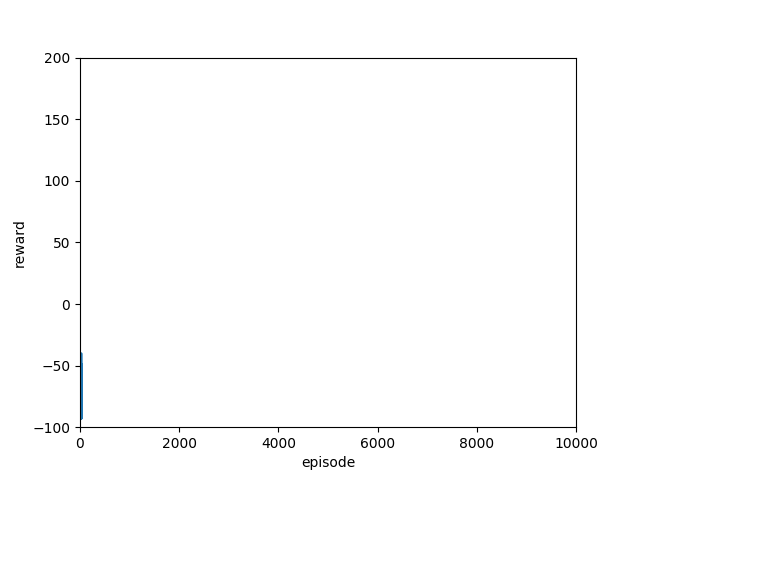

In [ ]:
buffer_size = 10000
batch_size = 32
gamma = 0.99
max_epsilon = 1
min_epsilon = 0.01
learning_rate = 0.001 
problem = 'CartPole-v0'
agent = Agent()
agent.train(10000)
#try_env(problem)
